In [8]:
import matplotlib.pyplot as plt
import uproot
import numpy as np
import pandas as pd

import sys
sys.path.insert(1, '/afs/desy.de/user/a/axelheim/private/MC_studies/Dstlnu_Bt_generic/util_funcs/')
from pandas_colFuncs import B_ID, whichBisSig, D0_decay_type, whichBisSig_NAHS



In [2]:
nfs_path = "/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/appliedNNdata/4thRun/"

In [3]:
Ups4S_file = uproot.open(nfs_path + "Ups4S_NN_predicted.root:variables;1")
df_Ups4S = Ups4S_file.arrays(library="pd")

In [4]:
FSPs_file = uproot.open(nfs_path + "FSPs.root:variables;1")
df_FSPs = FSPs_file.arrays(library="pd")

In [5]:
evt_counter_file = uproot.open(nfs_path + "evt_counter.root:variables;1")
df_evt_counter = evt_counter_file.arrays(library="pd")

In [76]:
df_evt_counter.groupby(["__event__","__production__"]).ngroups

9486265

## save df's

In [6]:
df_FSPs.to_csv(nfs_path + "FSPs_df.csv")

In [7]:
df_Ups4S.to_csv(nfs_path + "Ups4S_df.csv")

In [8]:
df_evt_counter.to_csv(nfs_path + "evt_counter_df.csv")

## load df's

In [3]:
df_Ups4S = pd.read_csv(nfs_path + "Ups4S_df.csv")
df_FSPs = pd.read_csv(nfs_path + "FSPs_df.csv")
df_evt_counter = pd.read_csv(nfs_path + "evt_counter_df.csv")

# Analysis

In [5]:
print(df_Ups4S.shape[0])
print(df_Ups4S["__event__"].nunique())
print(df_FSPs.shape[0])
print(df_evt_counter.shape[0])

136249
26305
498273
9486265


In [77]:
df_Ups4S.groupby(["__event__","__production__"]).ngroups

26307

## check DO decays

In [10]:
df_Ups4S['Bsig_uniqParID'] = df_Ups4S.apply(whichBisSig_NAHS, axis=1)

In [11]:
df_Ups4S['D0_decay'] = df_Ups4S.apply(D0_decay_type, axis=1)

In [12]:
df_Ups4S["abs_m2RecoilSignalSide"] = df_Ups4S["m2RecoilSignalSide"].abs() 
BCS_df = df_Ups4S.sort_values("abs_m2RecoilSignalSide",ascending=True).drop_duplicates(subset=("__event__"), keep='first')

In [13]:
BCS_df['D0_decay'].value_counts()

notWanted     18057
Kpipi0         4097
Kpipipipi0     1704
Kpipipi        1572
Kpi             875
Name: D0_decay, dtype: int64

In [14]:
BCS_df = BCS_df[BCS_df['D0_decay'] != "notWanted"]

In [15]:
df_FSPs = df_FSPs[df_FSPs['__event__'].isin(BCS_df["__event__"])]

### add and check cols

In [19]:
df_FSPs['B_ID'] = df_FSPs.apply(B_ID, axis=1)

In [20]:
BCS_df['Bsig_uniqParID_pdMethod'] = BCS_df.apply(whichBisSig, axis=1)

In [21]:
Hc_motherB_df = df_FSPs[df_FSPs["NN_prediction"].isna() == True].drop_duplicates(subset=("__event__"), keep='first')

In [22]:
Hc_motherB_df["B_tag_ID"] = Hc_motherB_df["B_ID"]

In [23]:
Hc_motherB_df[["__event__","__production__","B_ID","B_tag_ID","NN_prediction"]]

,__event__,__production__,B_ID,B_tag_ID,NN_prediction
5,2335906,16816,83886082,83886082,NaN
10,3672585,16816,83886081,83886081,NaN
29,2422,16816,83886081,83886081,NaN
31,3471,16816,83886081,83886081,NaN
45,4084548,16816,83886082,83886082,NaN
...,...,...,...,...,...
497903,1414971,16816,83886082,83886082,NaN
498058,6865940,16816,83886082,83886082,NaN
498095,477883,16816,83886081,83886081,NaN
498099,479935,16816,83886081,83886081,NaN


In [24]:
df_FSPs.shape[0]

150534

In [25]:
df_FSPs = pd.merge(df_FSPs,Hc_motherB_df[["__event__","__production__","B_tag_ID"]], on=["__event__","__production__"])

In [26]:
df_FSPs.shape[0]

149773

In [27]:
def labels(s):
    label = -1
    if int(s['B_ID']) == 0:
        label = 0 # background, cause not related to MC Particles
    else: 
        B_tagID = s['B_tag_ID']
        
        if int(s['B_ID']) == B_tagID:
            label = 1 # X
        else:
            label = 2 # Bsig
    return label
df_FSPs['label'] = df_FSPs.apply(labels, axis=1)

In [28]:
df_FSPs["correct_pred"] = (df_FSPs["label"] == df_FSPs["NN_prediction"]).astype(int)

In [29]:
df_FSPs["correct_pred"].describe()

count    149773.000000
mean          0.524868
std           0.499383
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: correct_pred, dtype: float64

In [30]:
df_FSPs[["__event__","B_ID","NN_prediction","B_tag_ID","label"]][:20]

,__event__,B_ID,NN_prediction,B_tag_ID,label
0,2335906,83886082,1.0,83886082,1
1,2335906,83886082,NaN,83886082,1
2,2335906,83886081,2.0,83886082,2
3,2335906,83886082,NaN,83886082,1
4,2335906,0,0.0,83886082,0
5,2335906,83886082,NaN,83886082,1
6,2335906,83886082,0.0,83886082,1
7,2335906,83886081,1.0,83886082,2
8,2335906,83886082,2.0,83886082,1
9,2335906,83886082,1.0,83886082,1


## see correct prediction rate of NN

In [31]:
df_FSPs["correct_pred"].describe()

count    149773.000000
mean          0.524868
std           0.499383
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: correct_pred, dtype: float64

In [32]:
df_FSPs["NN_prediction"].describe()

count    123335.000000
mean          1.206300
std           0.740412
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           2.000000
Name: NN_prediction, dtype: float64

In [33]:
df_FSPs[df_FSPs["NN_prediction"].notna() == True].shape[0]/df_FSPs.shape[0]

0.8234795323589699

In [34]:
nonHc_FSPs = df_FSPs[df_FSPs["NN_prediction"].notna() == True]

In [35]:
nonHc_FSPs[nonHc_FSPs["NN_prediction"].notna() == True].shape[0]/nonHc_FSPs.shape[0]

1.0

In [36]:
nonHc_FSPs["correct_pred"].describe()

count    123335.000000
mean          0.637378
std           0.480759
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: correct_pred, dtype: float64

In [37]:
nonHc_FSPs.shape[0]

123335

<AxesSubplot:>

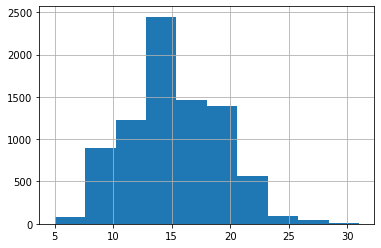

In [38]:
numFSPs_all = pd.DataFrame({'count' : nonHc_FSPs.groupby( ["__event__","__production__"] ).size()}).reset_index()
numFSPs_all["count"].hist()

In [26]:
percCorrect_df = pd.DataFrame({'frac. correct FSPs' : nonHc_FSPs.groupby(["__event__","__production__","correct_pred"] ).size()/nonHc_FSPs.groupby( ["__event__","__production__"] ).size()}).reset_index()

<AxesSubplot:>

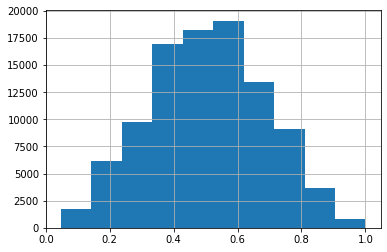

In [27]:
percCorrect_df['frac. correct FSPs'].hist()

## BCS

In [28]:
print(df_Ups4S.shape[0])
print(df_Ups4S["__event__"].nunique())
print(df_FSPs.shape[0])

258264
49904
938720


In [29]:
df_FSPs.keys()

Index(['Unnamed: 0', '__experiment__', '__run__', '__event__',
       '__production__', '__candidate__', '__ncandidates__', '__weight__',
       'genMothPDG_0', 'genMothPDG_1', 'genMothPDG_2', 'genMothPDG_3',
       'genMothPDG_4', 'genMothPDG_5', 'genMothPDG_6', 'genMothPDG_7',
       'genMothPDG_8', 'genMothPDG_9', 'genMotherID_0', 'genMotherID_1',
       'genMotherID_2', 'genMotherID_3', 'genMotherID_4', 'genMotherID_5',
       'genMotherID_6', 'genMotherID_7', 'genMotherID_8', 'genMotherID_9',
       'mcMother0_uniqParID', 'mcMother1_uniqParID', 'mcMother2_uniqParID',
       'mcMother3_uniqParID', 'mcMother4_uniqParID', 'mcMother5_uniqParID',
       'mcMother6_uniqParID', 'mcMother7_uniqParID', 'mcMother8_uniqParID',
       'mcMother9_uniqParID', 'cmpx', 'cmpy', 'cmpz', 'cmE', 'isSignal',
       'uniqueParticleIdentifier', 'mcErrors', 'mcPDG', 'genMotherID',
       'genMotherP', 'genMotherPDG', 'charge', 'dr', 'dz', 'clusterReg',
       'clusterE9E21', 'M', 'PDG', 'genParticleID', 

In [30]:
for key in df_Ups4S.keys():
    print(key)

Unnamed: 0
__experiment__
__run__
__event__
__production__
__candidate__
__ncandidates__
__weight__
m2RecoilSignalSide
foxWolframR2_maskedNaN
foxWolframR2
extraInfo__boFEIProbabilityRank__bc
nTracks
dau1_sigProb
Up4S_isSig
BeamE
BeamPx
BeamPy
BeamPz
BeamcmsE
BeamcmsPx
BeamcmsPy
BeamcmsPz
genUp4S_PDG_0
genUp4S_charge_0
genUp4S_mdstIndex_0
genUp4S_genParticleID_0
genUp4S_E_0
genUp4S_Px_0
genUp4S_Py_0
genUp4S_Pz_0
genUp4S_P_0
genUp4S_cmE_0
genUp4S_cmPx_0
genUp4S_cmPy_0
genUp4S_cmPz_0
genUp4S_cmP_0
genUp4S_uniqParID_0
genUp4S_PDG_0_0
genUp4S_mdstIndex_0_0
genUp4S_genParticleID_0_0
genUp4S_uniqParID_0_0
genUp4S_PDG_0_0_0
genUp4S_mdstIndex_0_0_0
genUp4S_genParticleID_0_0_0
genUp4S_uniqParID_0_0_0
genUp4S_PDG_0_0_1
genUp4S_mdstIndex_0_0_1
genUp4S_genParticleID_0_0_1
genUp4S_uniqParID_0_0_1
genUp4S_PDG_0_1
genUp4S_mdstIndex_0_1
genUp4S_genParticleID_0_1
genUp4S_uniqParID_0_1
genUp4S_PDG_0_2
genUp4S_mdstIndex_0_2
genUp4S_genParticleID_0_2
genUp4S_uniqParID_0_2
genUp4S_PDG_1
genUp4S_charge_1
gen

In [33]:
df_Ups4S.shape[0]

258264

In [36]:
df_Ups4S[["__event__"]].nunique()

__event__    49904
dtype: int64

In [37]:
df_Ups4S.groupby(["__event__","__production__"]).ngroups

49914

In [41]:
variables=["Up4S_isSig","Dst_isSignal","D_isSignal","dau0_dau0_isSignal","Hc_isSignalAcceptMissingGamma","dau0_isSignal","dau1_isSignal"]
for var in variables:
    print('\n',var)
    print(df_Ups4S[var].describe())
    


 Up4S_isSig
count    60876.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: Up4S_isSig, dtype: float64

 Dst_isSignal
count    116843.000000
mean          0.001010
std           0.031763
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Dst_isSignal, dtype: float64

 D_isSignal
count    118034.000000
mean          0.003287
std           0.057240
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: D_isSignal, dtype: float64

 dau0_dau0_isSignal
count    136249.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: dau0_dau0_isSignal, dtype: float64

 Hc_isSignalAcceptMissingGamma
count    136249.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%     

<AxesSubplot:>

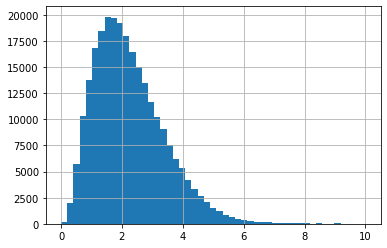

In [10]:
bins = np.linspace(0, 10, 50)
df_Ups4S["roeE_ofUps4S"].hist(bins=bins)

<AxesSubplot:>

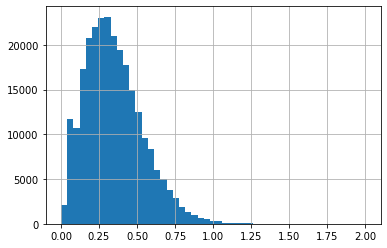

In [12]:
bins = np.linspace(0, 2, 50)
df_Ups4S["E_predicted_bg_gammas"].hist(bins=bins)

<AxesSubplot:>

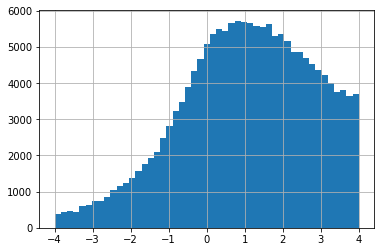

In [13]:
bins = np.linspace(-4, 4, 50)
df_Ups4S["m2RecoilSignalSide"].hist(bins=bins)

In [16]:
df_Ups4S["Up4S_isSig"].describe()

count    116102.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: Up4S_isSig, dtype: float64

26305
26305


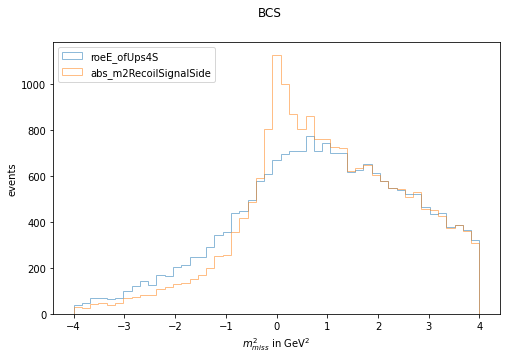

In [71]:
df_Ups4S["abs_m2RecoilSignalSide"] = df_Ups4S["m2RecoilSignalSide"].abs() 
fig, ax = plt.subplots()
fig.suptitle('BCS')

for var in ["roeE_ofUps4S","abs_m2RecoilSignalSide"]:
    
    tmp = df_Ups4S.sort_values(var,ascending=True).drop_duplicates(subset=("__event__"), keep='first')
    print(tmp.shape[0])
    bins = np.linspace(-4, 4, 50)
    
    fig.set_size_inches(8, 5)

    ax.set_xlabel(r'$m_{miss}^2$ in GeV$^2$')
    ax.set_ylabel("events")

    ax.hist(tmp.m2RecoilSignalSide, bins, alpha=0.5, label=var ,histtype='step')

    ax.legend(loc='upper left')


    
plt.savefig('plots/onlineNN_m2Recoil_BCS.pdf')

In [27]:
BCS_df = df_Ups4S.sort_values("abs_m2RecoilSignalSide",ascending=True).drop_duplicates(subset=("__event__"), keep='first')

In [28]:
BCS_df

,Unnamed: 0,__experiment__,__run__,__event__,__production__,__candidate__,__ncandidates__,__weight__,m2RecoilSignalSide,foxWolframR2_maskedNaN,...,Dst_mccmE,Dst_mccmp,Dst_mccmpx,Dst_mccmpy,Dst_mccmpz,Dst_DeltaM,Dst_isSignal,roeE_ofUps4S,E_predicted_bg_gammas,abs_m2RecoilSignalSide
141910,141910,1003,0,47846429,16817,3,4,1.0,-0.000037,0.135923,...,10.574087,0.000462,-2.697498e-06,0.000000,-0.000462,0.148945,0.0,0.604866,0.346684,0.000037
235950,235950,1003,0,6089413,16816,1,8,1.0,0.000099,0.061840,...,10.581256,0.003940,2.271547e-05,0.000000,0.003940,0.158790,0.0,0.697127,0.079790,0.000099
156316,156316,1003,0,49935203,16817,3,4,1.0,0.000107,0.195361,...,10.587143,0.000590,-3.382417e-06,0.000000,-0.000590,0.325629,0.0,1.307764,0.235975,0.000107
198018,198018,1003,0,13273233,16817,0,2,1.0,-0.000145,0.083021,...,10.582830,0.000108,-6.006459e-07,0.000000,-0.000108,0.285363,0.0,1.818166,0.290686,0.000145
146588,146588,1003,0,50046312,16817,7,8,1.0,-0.000163,0.089173,...,10.587262,0.000803,4.627266e-06,0.000000,0.000803,0.274863,0.0,2.053069,0.413075,0.000163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13513,13513,1003,0,1706707,16816,0,2,1.0,-17.344737,0.068277,...,10.575372,0.001366,-7.869317e-06,0.000000,-0.001366,0.634118,0.0,0.920907,0.500107,17.344737
9660,9660,1003,0,44025196,16816,1,2,1.0,-21.184315,0.152776,...,2.907935,2.101110,-1.555178e+00,1.003136,0.994889,0.153017,0.0,2.399377,0.303804,21.184315
128660,128660,1003,0,38157178,16817,0,8,1.0,-26.499164,0.068405,...,10.588659,0.000492,2.819186e-06,0.000000,0.000492,0.169219,0.0,3.700169,0.664777,26.499164
202523,202523,1003,0,33540556,16817,3,4,1.0,-88.968916,0.218392,...,10.574317,0.005166,-2.984147e-05,0.000000,-0.005166,0.267390,0.0,3.364213,0.284748,88.968916


<AxesSubplot:>

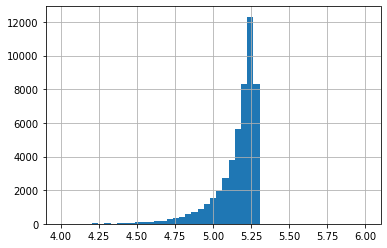

In [32]:
bins = np.linspace(4, 6, 50)
BCS_df["dau0_Mbc"].hist(bins=bins)

<AxesSubplot:>

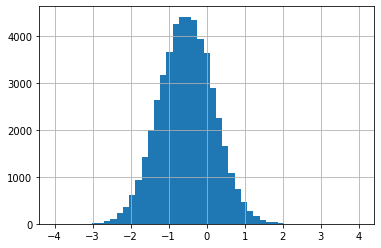

In [35]:
bins = np.linspace(-4, 4, 50)
BCS_df["dau0_deltaE"].hist(bins=bins)

<AxesSubplot:>

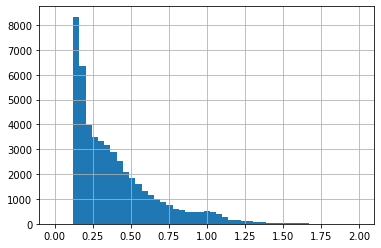

In [55]:
bins = np.linspace(0, 2, 50)
BCS_df["Dst_DeltaM"].hist(bins=bins)

<AxesSubplot:>

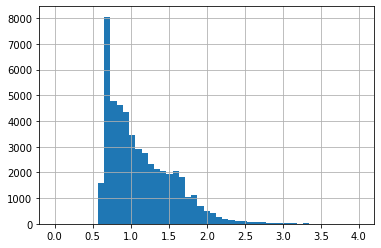

In [58]:
bins = np.linspace(0, 4, 50)
BCS_df["D_M"].hist(bins=bins)

<AxesSubplot:>

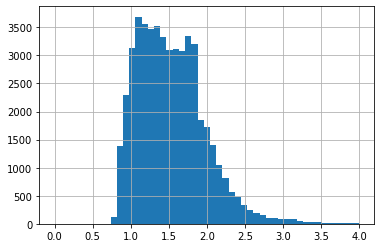

In [59]:
bins = np.linspace(0, 4, 50)
BCS_df["Dst_M"].hist(bins=bins)

<AxesSubplot:>

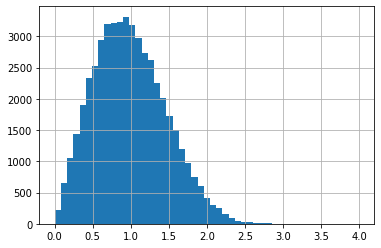

In [39]:
bins = np.linspace(0, 4, 50)
BCS_df["Dst_pt"].hist(bins=bins)

<AxesSubplot:>

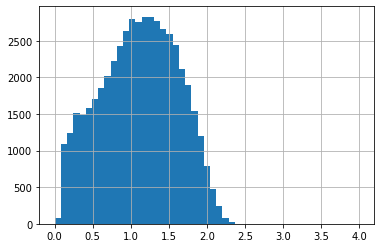

In [40]:
bins = np.linspace(0, 4, 50)
BCS_df["lep_pt"].hist(bins=bins)

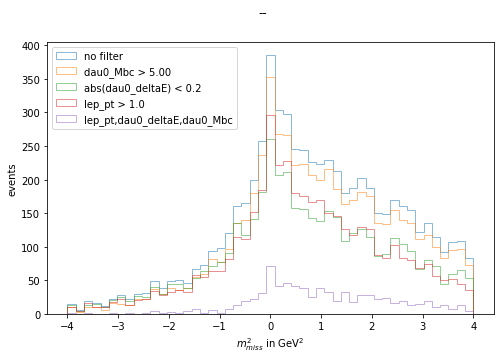

In [69]:
fig, ax = plt.subplots()
    
bins = np.linspace(-4, 4, 50)

fig.suptitle('--')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'$m_{miss}^2$ in GeV$^2$')
ax.set_ylabel("events")

ax.hist(BCS_df.m2RecoilSignalSide, bins, alpha=0.5, label="no filter" ,histtype='step')
ax.hist(BCS_df[BCS_df.dau0_Mbc > 5.00].m2RecoilSignalSide, bins, alpha=0.5, label="dau0_Mbc > 5.00" ,histtype='step')
ax.hist(BCS_df[(BCS_df.dau0_deltaE > -.2) & BCS_df.dau0_deltaE < .2].m2RecoilSignalSide, bins, alpha=0.5, label="abs(dau0_deltaE) < 0.2" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.Dst_pt < 2.4) & (BCS_df.lep_pt > 1.0)].m2RecoilSignalSide, bins, alpha=0.5, label="Dst_pt < 2.4 & lep_pt > 1.0" ,histtype='step')
ax.hist(BCS_df[(BCS_df.lep_pt > 1.0)].m2RecoilSignalSide, bins, alpha=0.5, label="lep_pt > 1.0" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.Dst_pt < 2.4)].m2RecoilSignalSide, bins, alpha=0.5, label="Dst_pt < 2.4" ,histtype='step')
ax.hist(BCS_df[(BCS_df.lep_pt > 1.0) & (BCS_df.dau0_deltaE > -.2) & (BCS_df.dau0_deltaE < .2) & (BCS_df.dau0_Mbc > 5.00)].m2RecoilSignalSide, bins, alpha=0.5, label="lep_pt,dau0_deltaE,dau0_Mbc" ,histtype='step')

#tmp2 = BCS_df[(BCS_df.lep_pt > 1.0) & (BCS_df.dau0_deltaE > -.2) & (BCS_df.dau0_deltaE < .2) & (BCS_df.dau0_Mbc > 5.00)]
#ax.hist(tmp2[(tmp2.D_M > 1.8) & (tmp2.D_M < 1.95)].m2RecoilSignalSide, bins, alpha=0.5, label="plus D M cut" ,histtype='step')

ax.legend(loc='upper left')


plt.savefig('plots/onlineNN_m2RecoilFilters.pdf')

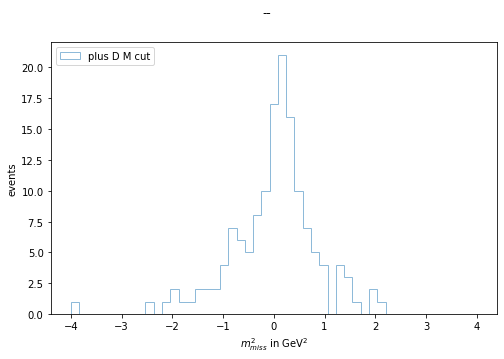

In [40]:
fig, ax = plt.subplots()
    
bins = np.linspace(-4, 4, 50)

fig.suptitle('--')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'$m_{miss}^2$ in GeV$^2$')
ax.set_ylabel("events")

#ax.hist(BCS_df.m2RecoilSignalSide, bins, alpha=0.5, label="no filter" ,histtype='step')
#ax.hist(BCS_df[BCS_df.dau0_Mbc > 5.00].m2RecoilSignalSide, bins, alpha=0.5, label="dau0_Mbc > 5.00" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.dau0_deltaE > -.2) & BCS_df.dau0_deltaE < .2].m2RecoilSignalSide, bins, alpha=0.5, label="abs(dau0_deltaE) < 0.2" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.Dst_pt < 2.4) & (BCS_df.lep_pt > 1.0)].m2RecoilSignalSide, bins, alpha=0.5, label="Dst_pt < 2.4 & lep_pt > 1.0" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.lep_pt > 1.0)].m2RecoilSignalSide, bins, alpha=0.5, label="lep_pt > 1.0" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.Dst_pt < 2.4)].m2RecoilSignalSide, bins, alpha=0.5, label="Dst_pt < 2.4" ,histtype='step')
#ax.hist(BCS_df[(BCS_df.lep_pt > 1.0) & (BCS_df.dau0_deltaE > -.2) & (BCS_df.dau0_deltaE < .2) & (BCS_df.dau0_Mbc > 5.00)].m2RecoilSignalSide, bins, alpha=0.5, label="lep_pt,dau0_deltaE,dau0_Mbc" ,histtype='step')

tmp2 = BCS_df[(BCS_df.lep_pt > 1.0) & (BCS_df.dau0_deltaE > -.2) & (BCS_df.dau0_deltaE < .2) & (BCS_df.dau0_Mbc > 5.00)]
ax.hist(tmp2[(tmp2.D_M > 1.8) & (tmp2.D_M < 1.95)].m2RecoilSignalSide, bins, alpha=0.5, label="plus D M cut" ,histtype='step')

ax.legend(loc='upper left')

## analyse how many errors per evt etc

In [43]:
percCorrect_df = pd.DataFrame({'frac. correct FSPs' : nonHc_FSPs.groupby(["__event__","correct_pred"] ).size()/nonHc_FSPs.groupby( ["__event__"] ).size(),
                              'num corr preds' : nonHc_FSPs.groupby(["__event__","correct_pred"] ).size()}).reset_index()
percCorrect_df = percCorrect_df[percCorrect_df["correct_pred"] == 1]
numFSPs = pd.DataFrame({'numFSPs' : nonHc_FSPs.groupby( ["__event__"] ).size()}).reset_index()

online_NN_results = pd.merge(percCorrect_df[["__event__","frac. correct FSPs","num corr preds"]],
                             numFSPs[["__event__","numFSPs"]],on=["__event__"],how='outer')
online_NN_results

,__event__,frac. correct FSPs,num corr preds,numFSPs
0,2422,0.687500,11,16
1,2515,0.384615,5,13
2,3471,0.714286,10,14
3,3765,0.750000,12,16
4,5639,0.555556,10,18
...,...,...,...,...
8198,50971725,0.764706,13,17
8199,50980002,0.538462,7,13
8200,50982065,0.608696,14,23
8201,50988729,0.533333,8,15


In [44]:
online_NN_results['frac. correct FSPs'] = online_NN_results['frac. correct FSPs'].fillna(0)
online_NN_results['num corr preds'] = online_NN_results['num corr preds'].fillna(0)

In [45]:
online_NN_results["num errors"] = online_NN_results["numFSPs"] - online_NN_results["num corr preds"]

## make comparison plots between online/offline application of NN

In [39]:
path_df = "/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/MM2plotFromPreds/"
offline_NN_results = pd.read_csv(path_df + "offline_NN_results.csv")

In [40]:
offline_NN_results.keys()

Index(['Unnamed: 0', 'event', 'frac. correct FSPs', 'num corr preds',
       'numFSPs', 'px_summed_bg', 'py_summed_bg', 'pz_summed_bg',
       'E_summed_bg', 'CMSpx_summed_bg', 'CMSpy_summed_bg', 'CMSpz_summed_bg',
       'CMSE_summed_bg', 'px_summed_X', 'py_summed_X', 'pz_summed_X',
       'E_summed_X', 'CMSpx_summed_X', 'CMSpy_summed_X', 'CMSpz_summed_X',
       'CMSE_summed_X', 'px_summed_Bs', 'py_summed_Bs', 'pz_summed_Bs',
       'E_summed_Bs', 'CMSpx_summed_Bs', 'CMSpy_summed_Bs', 'CMSpz_summed_Bs',
       'CMSE_summed_Bs', 'Hc_px', 'Hc_py', 'Hc_pz', 'Hc_E', 'Hc_cmpx',
       'Hc_cmpy', 'Hc_cmpz', 'Hc_cmE', 'Hc_cmPx', 'Hc_cmPy', 'Hc_cmPz',
       'num errors', 'Mbc_Btag', 'MM2recoilSignalSide', 'deltaE',
       'summed_wrongPred_p'],
      dtype='object')

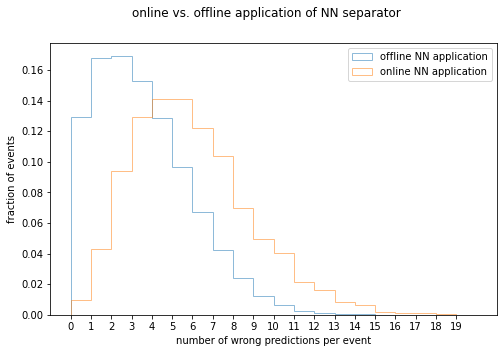

In [75]:
fig, ax = plt.subplots()
num_steps=20
bins = np.linspace(0, num_steps, 21)

fig.suptitle('online vs. offline application of NN separator')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'number of wrong predictions per event')
ax.set_ylabel("fraction of events")

plt.xticks(np.arange(0, num_steps, step=1))

ax.hist(offline_NN_results["num errors"], bins, density=True, alpha=0.5, label="offline NN application" ,histtype='step')
ax.hist(online_NN_results["num errors"], bins, density=True, alpha=0.5, label="online NN application" ,histtype='step')

ax.legend(loc='upper right')

#plt.grid()

plt.savefig('plots/onlineVSofflineNN_numErrorsPerEvent.pdf')

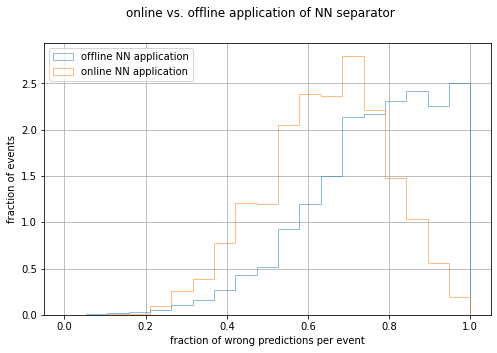

In [73]:
fig, ax = plt.subplots()

bins = np.linspace(0, 1, 20)

fig.suptitle('online vs. offline application of NN separator')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'fraction of wrong predictions per event')
ax.set_ylabel("fraction of events")

ax.hist(offline_NN_results["frac. correct FSPs"], bins, density=True, alpha=0.5, label="offline NN application" ,histtype='step')
ax.hist(online_NN_results["frac. correct FSPs"], bins, density=True, alpha=0.5, label="online NN application" ,histtype='step')

ax.legend(loc='upper left')

plt.grid()

plt.savefig('plots/onlineVSofflineNN_fracErrorsPerEvent.pdf')

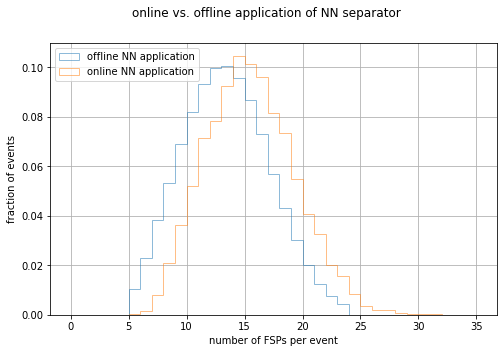

In [68]:
fig, ax = plt.subplots()

bins = np.linspace(0, 35, 36)

fig.suptitle('online vs. offline application of NN separator')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'number of FSPs per event')
ax.set_ylabel("fraction of events")

ax.hist(offline_NN_results["numFSPs"], bins, density=True, alpha=0.5, label="offline NN application" ,histtype='step')
ax.hist(online_NN_results["numFSPs"], bins, density=True, alpha=0.5, label="online NN application" ,histtype='step')

ax.legend(loc='upper left')

plt.grid()

plt.savefig('plots/onlineVSofflineNN_numFSPs.pdf')

In [2]:
import torch
r = torch.Tensor([ 5,  7,  9,  8,  1, 11,  2,  4,  0, 10,  6,  3])

for j in range(len(r)):
    print(r[j].item())
    print((r == j).nonzero(as_tuple=True)[0].item(), '\n')

5.0
8 

7.0
4 

9.0
6 

8.0
11 

1.0
7 

11.0
0 

2.0
10 

4.0
1 

0.0
3 

10.0
2 

6.0
9 

3.0
5 

